In [34]:
# ===========================================================
#  library
# ===========================================================
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [35]:
# ===========================================================
#  CFG
# ===========================================================
class CFG:
    seed = 42
    n_splits = 5
    data_dir = "G:/マイドライブ/signate_MUFJ2023/data/"
    num_boost_round = 10000
    stopping_rounds = 1500
    save_dir = "G:/マイドライブ/signate_MUFJ2023/exp/"

In [36]:
# ===========================================================
#  Utils
# ===========================================================
def seed_everything(seed):
    """fix random factors"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
seed_everything(CFG.seed)


def get_score(y_true, y_pred):
    """
    評価関数の入力となる検証用データ、及び学習に使用する学習用データの目的変数について、
    1: 不正利用あり, 0: 不正利用なしとします。
    """
    return f1_score(y_true, y_pred)

In [37]:
# ===============================================================
#  Data Loading
# ===============================================================
train = pd.read_csv(CFG.data_dir+"train.csv")
test = pd.read_csv(CFG.data_dir+"test.csv")
card = pd.read_csv(CFG.data_dir+"card.csv")
user = pd.read_csv(CFG.data_dir+"user.csv")

train["flag"] = "train"
test["flag"] = "test"
all_data = pd.concat([train, test], ignore_index=True)
all_data = pd.merge(all_data, card, on=["user_id", "card_id"], how="left")
all_data = pd.merge(all_data, user, on="user_id", how="left")

In [38]:
# ===============================================================
#  Preprocessing
# ===============================================================
def preprocessing(all_data: pd.DataFrame) -> pd.DataFrame:
    """
    
    trainとtestで共通の前処理
    
    ･ stringからfloatに変換
        金額 : amount, credit_limit, per_capita_income_zipcode, yearly_income_person, total_debt 
               (ex) "$100" -> 100
        日付 : expires, acct_open_date    
               (ex) "08/23" -> 8, 24
        
    ･ 欠損値の処理
        merchant_stateの欠損値は全てmerchant_cityが"ONLINE"のときなので故意の欠損値
        zipの欠損値は、merchant_cityがアメリカ合衆国以外の場合におこっているので故意の欠損値

    Args:
        CFG : config
        all_data (pd.DataFrame): pd.concat([train, test], ignore_index=True)

    Returns:
        pd.DataFrame: 前処理済みのall_data
    """
    # 金額
    ## amount
    all_data["amount"] = all_data["amount"].apply(lambda x:x[1:]).astype(float)
    ## total_debt
    all_data["total_debt"] = all_data["total_debt"].apply(lambda x:x[1:]).astype(float)
    ## credit_limit
    all_data['credit_limit'] = all_data['credit_limit'].apply(lambda x:x[1:]).astype(float)
    ## yearly_income_person	
    all_data["yearly_income_person"] = all_data["yearly_income_person"].apply(lambda x:x[1:]).astype(float)
    ## per_capita_income_zipcode
    all_data["per_capita_income_zipcode"] = all_data["per_capita_income_zipcode"].apply(lambda x:x[1:]).astype(float)

    # 日付
    ## expires
    all_data[["expires_month", "expires_year"]] = all_data["expires"].str.split("/", expand=True).astype(int)
    ## acct_open_date
    all_data[["acct_open_date_month", "acct_open_date_year"]] = all_data["acct_open_date"].str.split("/", expand=True).astype(int)
    
    return all_data
all_data = preprocessing(all_data)

## feature_engineering

In [56]:
feature_lists = []
for i, col1 in enumerate(all_data.columns):
    for col2 in all_data.columns[i+1:]:
        feature_lists.append(f"{col1}*{col2}")
len(feature_lists)

820

### user_id*card_id
無理そう

### user_id*amount
時系列が分からないから直近の平均とか出せないな。  

,Fraud_Avg_Amount,Non_Fraud_Avg_Amount
user_id,,
39,232.169895,145.585285
41,101.805448,56.908920
47,212.525232,103.477809
54,243.774757,60.545015
80,141.752806,62.788282


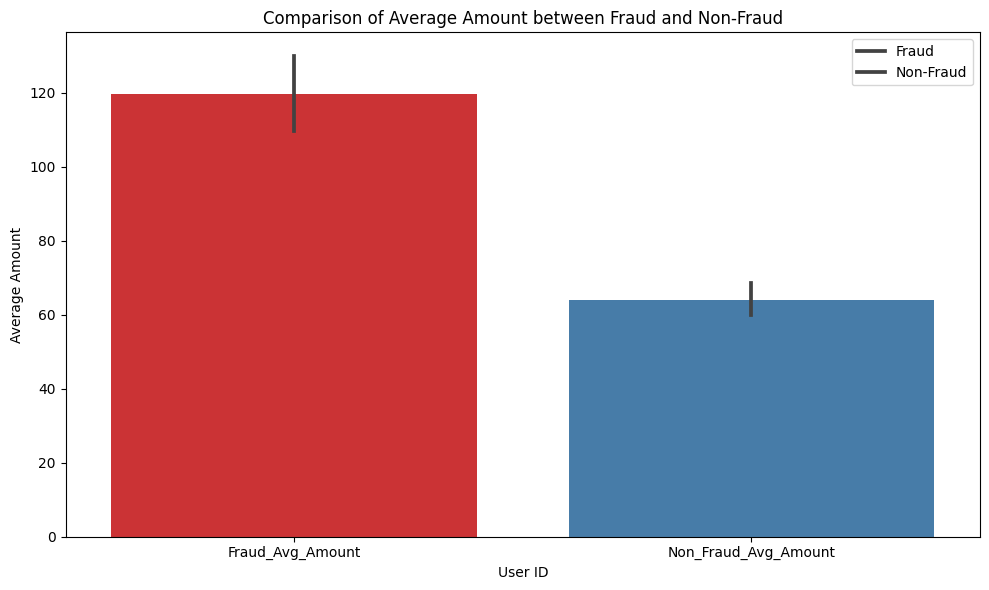

In [69]:
# FEATURE_IDEA: Cross Validationしたあとに"is_fraud_?"==0のときのユーザーごとの平均(中央値)を出して、その差を取る


# "is_fraud?"が1のときのデータを抽出
fraud_data = all_data[(all_data["flag"] == "train") & (all_data["is_fraud?"] == 1)]

# "is_fraud?"が0のときのデータを抽出
non_fraud_data = all_data[(all_data["flag"] == "train") & (all_data["is_fraud?"] == 0)]

# "is_fraud?"が1のときの"user_id"でグルーピングして"amount"の平均を計算
fraud_avg_amount = fraud_data.groupby("user_id")["amount"].mean()

# "is_fraud?"が0のときの"user_id"でグルーピングして"amount"の平均を計算
non_fraud_avg_amount = non_fraud_data.groupby("user_id")["amount"].mean()

# データの比較用データフレームを作成
comparison_df = pd.DataFrame({
    "Fraud_Avg_Amount": fraud_avg_amount,
    "Non_Fraud_Avg_Amount": non_fraud_avg_amount
})

display(comparison_df.head())

# 可視化
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df, palette="Set1")
plt.title("Comparison of Average Amount between Fraud and Non-Fraud")
plt.xlabel("User ID")
plt.ylabel("Average Amount")
plt.legend(["Fraud", "Non-Fraud"])
plt.tight_layout()
plt.show()

### user_id*errors?

In [70]:
all_data[all_data["flag"] == "train"][["user_id", "errors?", "is_fraud?"]]

,user_id,errors?,is_fraud?
0,1721,OK,0.0
1,1629,OK,0.0
2,655,OK,0.0
3,492,OK,0.0
4,1969,OK,0.0
...,...,...,...
471278,1572,OK,0.0
471279,837,OK,1.0
471280,1522,OK,0.0
471281,1328,OK,0.0


C:\Users\Komiyama Yuji\AppData\Local\Temp\ipykernel_24312\181227200.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_fraud_data["error?_map"] = non_fraud_data["errors?"].map(error_map)
C:\Users\Komiyama Yuji\AppData\Local\Temp\ipykernel_24312\181227200.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_data["error?_map"] = fraud_data["errors?"].map(error_map)


,Fraud_Avg_Error_Rate,Non_Fraud_Avg_Error_Rate
user_id,,
39,0.991935,0.928520
41,0.952862,0.866550
47,0.993548,0.888086
54,0.923611,0.872316
80,0.684375,0.855072


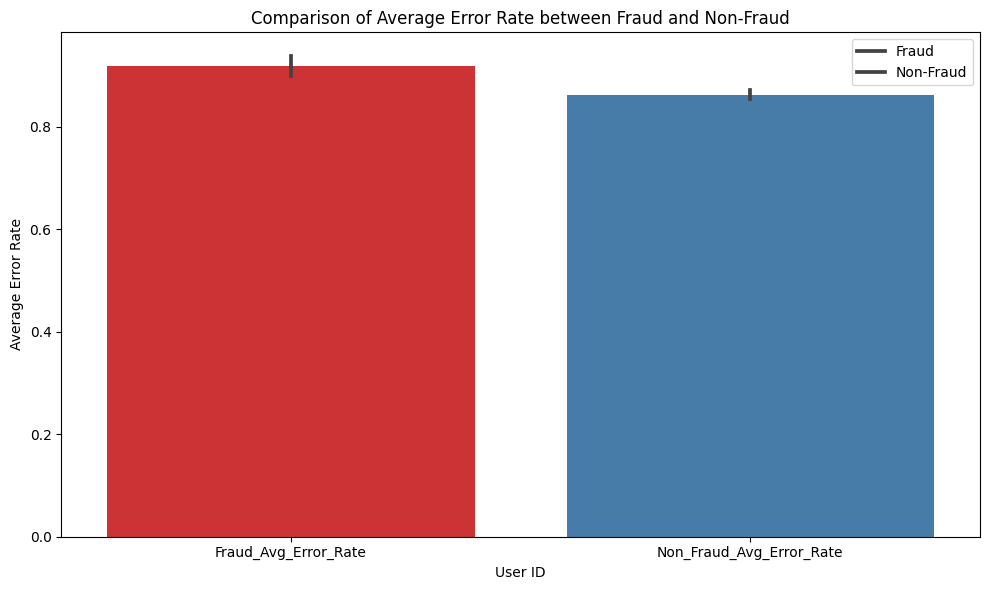

In [75]:
# FEATURE_IDEA: Cross Validationしたあとに"is_fraud_?"==0のときのユーザーごとの平均を出して、その差を取る


# "is_fraud?"が1のときのデータを抽出
fraud_data = all_data[(all_data["flag"] == "train") & (all_data["is_fraud?"] == 1)]

# "is_fraud?"が0のときのデータを抽出
non_fraud_data = all_data[(all_data["flag"] == "train") & (all_data["is_fraud?"] == 0)]

error_map = {
    "OK": 1,
    "ERROR": 0
}

# non-fraudとfraudのデータに対して"errors?"カラムをマッピング
non_fraud_data["error?_map"] = non_fraud_data["errors?"].map(error_map)
fraud_data["error?_map"] = fraud_data["errors?"].map(error_map)

# "is_fraud?"が1のときの"user_id"でグルーピングして"error?_map"の平均を計算
fraud_avg_error_rate = fraud_data.groupby("user_id")["error?_map"].mean()

# "is_fraud?"が0のときの"user_id"でグルーピングして"error?_map"の平均を計算
non_fraud_avg_error_rate = non_fraud_data.groupby("user_id")["error?_map"].mean()

# データの比較用データフレームを作成
comparison_df = pd.DataFrame({
    "Fraud_Avg_Error_Rate": fraud_avg_error_rate,
    "Non_Fraud_Avg_Error_Rate": non_fraud_avg_error_rate
})

display(comparison_df.head())

# 可視化
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df, palette="Set1")
plt.title("Comparison of Average Error Rate between Fraud and Non-Fraud")
plt.xlabel("User ID")
plt.ylabel("Average Error Rate")
plt.legend(["Fraud", "Non-Fraud"])
plt.tight_layout()
plt.show()

### user_id*merchant_id

In [81]:
all_data["concatenated_ids"] = all_data["user_id"].astype(str) + all_data["merchant_id"].astype(str)
all_data["concatenated_ids"]

0         1721209237
1           16292568
2          655345310
3            4924295
4         1969350447
             ...    
929236    1444226313
929237     720132248
929238    1773284589
929239     156342384
929240    1571260546
Name: concatenated_ids, Length: 929241, dtype: object

In [90]:
all_data[all_data["flag"] == "train"]["concatenated_ids"].value_counts()

concatenated_ids
1612257539    1903
492226657     1858
1592121879    1353
1328353401    1163
1661123039    1074
              ... 
1389289282       1
774353700        1
1086328436       1
1526303761       1
10973097         1
Name: count, Length: 33566, dtype: int64

In [86]:
# FEATURE_IDEA: Cross Validationしたあとに過去にその店を使ったことがあるかどうか(or 回数)の特徴量を作る

len(all_data[all_data["flag"] == "train"]["concatenated_ids"].unique())

33566

C:\Users\Komiyama Yuji\AppData\Local\Temp\ipykernel_24312\4283110194.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["multiple_appearances"] = train_data["concatenated_ids"].map(ids_counts) > 1


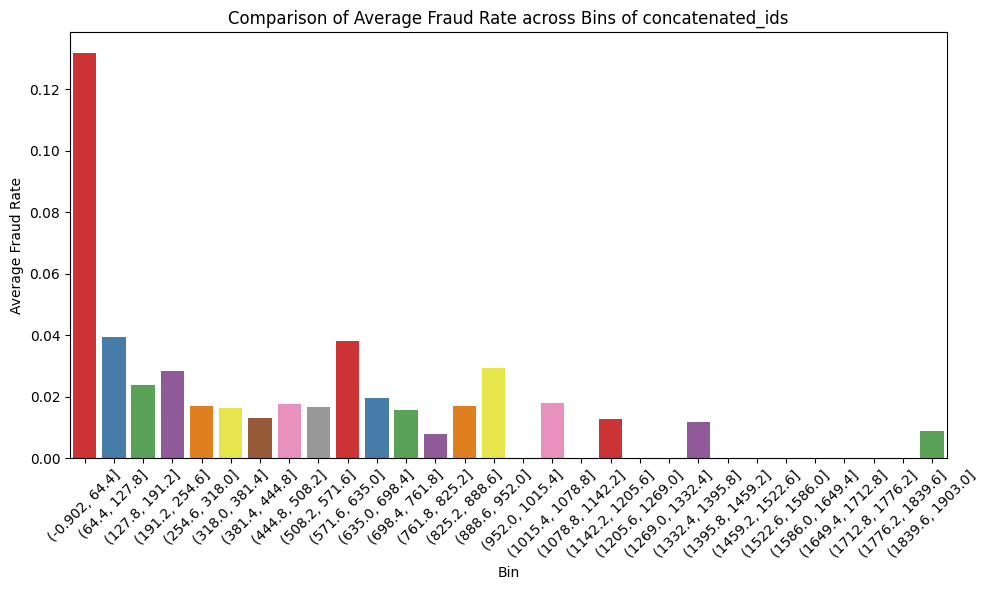

In [92]:
# "flag"が"train"のデータを抽出
train_data = all_data[all_data["flag"] == "train"]

# "concatenated_ids"の出現回数を計算
ids_counts = train_data["concatenated_ids"].value_counts()

# "concatenated_ids"が複数回出現しているかどうかを判定し、新しいカラムを追加
train_data["multiple_appearances"] = train_data["concatenated_ids"].map(ids_counts) > 1

# 新しいDataFrameを作成
bins = pd.cut(ids_counts, bins=30)  # ヒストグラムのbin数を指定
binned_data = pd.DataFrame({
    "concatenated_ids": ids_counts.index,
    "bin": bins.values
})

# 各binの中での"is_fraud?"の平均を計算
bin_fraud_rate = binned_data.groupby("bin").apply(lambda x: train_data[train_data["concatenated_ids"].isin(x["concatenated_ids"])]["is_fraud?"].mean())

# 可視化
plt.figure(figsize=(10, 6))
sns.barplot(x=bin_fraud_rate.index, y=bin_fraud_rate.values, palette="Set1")
plt.title("Comparison of Average Fraud Rate across Bins of concatenated_ids")
plt.xlabel("Bin")
plt.ylabel("Average Fraud Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### user_id*merchant_city

In [94]:
all_data[all_data["flag"] == "train"][["user_id", "merchant_city", "is_fraud?"]]

,user_id,merchant_city,is_fraud?
0,1721,Joliet,0.0
1,1629,Edgerton,0.0
2,655,Ridgefield,0.0
3,492,Milton,0.0
4,1969,Irvington,0.0
...,...,...,...
471278,1572,Lake Orion,0.0
471279,837,Norcross,1.0
471280,1522,Novato,0.0
471281,1328,ONLINE,0.0


C:\Users\Komiyama Yuji\AppData\Local\Temp\ipykernel_24312\401903153.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["multiple_appearances"] = train_data["concatenated_ids"].map(ids_counts) > 1


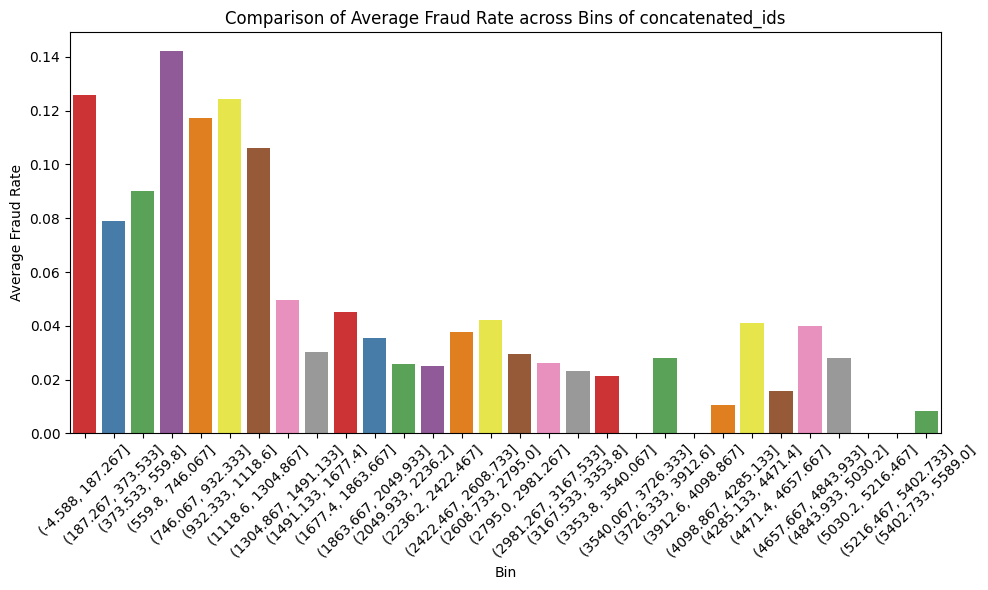

In [95]:
# FEATURE_IDEA: Cross Validationしたあとに過去にその街を使ったことがあるかどうか(or 回数)の特徴量を作る


all_data["concatenated_ids"] = all_data["user_id"].astype(str) + all_data["merchant_city"].astype(str)
# "flag"が"train"のデータを抽出
train_data = all_data[all_data["flag"] == "train"]

# "concatenated_ids"の出現回数を計算
ids_counts = train_data["concatenated_ids"].value_counts()

# "concatenated_ids"が複数回出現しているかどうかを判定し、新しいカラムを追加
train_data["multiple_appearances"] = train_data["concatenated_ids"].map(ids_counts) > 1

# 新しいDataFrameを作成
bins = pd.cut(ids_counts, bins=30)  # ヒストグラムのbin数を指定
binned_data = pd.DataFrame({
    "concatenated_ids": ids_counts.index,
    "bin": bins.values
})

# 各binの中での"is_fraud?"の平均を計算
bin_fraud_rate = binned_data.groupby("bin").apply(lambda x: train_data[train_data["concatenated_ids"].isin(x["concatenated_ids"])]["is_fraud?"].mean())

# 可視化
plt.figure(figsize=(10, 6))
sns.barplot(x=bin_fraud_rate.index, y=bin_fraud_rate.values, palette="Set1")
plt.title("Comparison of Average Fraud Rate across Bins of concatenated_ids")
plt.xlabel("Bin")
plt.ylabel("Average Fraud Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### user_id*merchant_state

C:\Users\Komiyama Yuji\AppData\Local\Temp\ipykernel_24312\560043755.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["multiple_appearances"] = train_data["concatenated_ids"].map(ids_counts) > 1


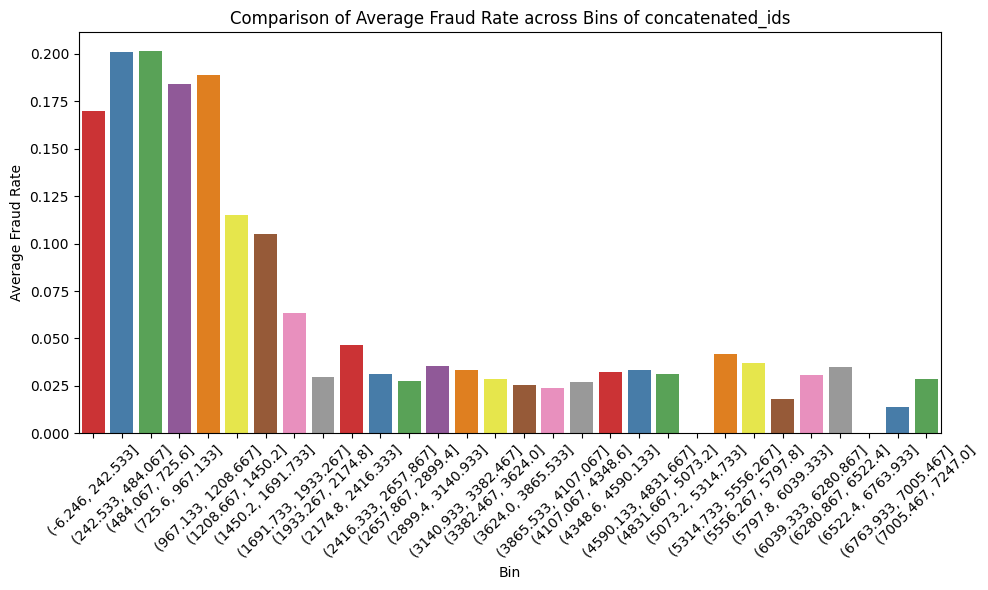

In [97]:
# FEATURE_IDEA: Cross Validationしたあとに過去にその街を使ったことがあるかどうか(or 回数)の特徴量を作る


all_data["concatenated_ids"] = all_data["user_id"].astype(str) + all_data["merchant_state"].astype(str)
# "flag"が"train"のデータを抽出
train_data = all_data[all_data["flag"] == "train"]

# "concatenated_ids"の出現回数を計算
ids_counts = train_data["concatenated_ids"].value_counts()

# "concatenated_ids"が複数回出現しているかどうかを判定し、新しいカラムを追加
train_data["multiple_appearances"] = train_data["concatenated_ids"].map(ids_counts) > 1

# 新しいDataFrameを作成
bins = pd.cut(ids_counts, bins=30)  # ヒストグラムのbin数を指定
binned_data = pd.DataFrame({
    "concatenated_ids": ids_counts.index,
    "bin": bins.values
})

# 各binの中での"is_fraud?"の平均を計算
bin_fraud_rate = binned_data.groupby("bin").apply(lambda x: train_data[train_data["concatenated_ids"].isin(x["concatenated_ids"])]["is_fraud?"].mean())

# 可視化
plt.figure(figsize=(10, 6))
sns.barplot(x=bin_fraud_rate.index, y=bin_fraud_rate.values, palette="Set1")
plt.title("Comparison of Average Fraud Rate across Bins of concatenated_ids")
plt.xlabel("Bin")
plt.ylabel("Average Fraud Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### user_id*zip

In [98]:
all_data[all_data["flag"] == "train"][["user_id", "zip", "zipcode", "is_fraud?"]]

,user_id,zip,zipcode,is_fraud?
0,1721,60436.0,60436,0.0
1,1629,53534.0,53534,0.0
2,655,98642.0,98642,0.0
3,492,32583.0,57107,0.0
4,1969,7111.0,7087,0.0
...,...,...,...,...
471278,1572,48362.0,48357,0.0
471279,837,30092.0,30084,1.0
471280,1522,94947.0,94947,0.0
471281,1328,NaN,59044,0.0


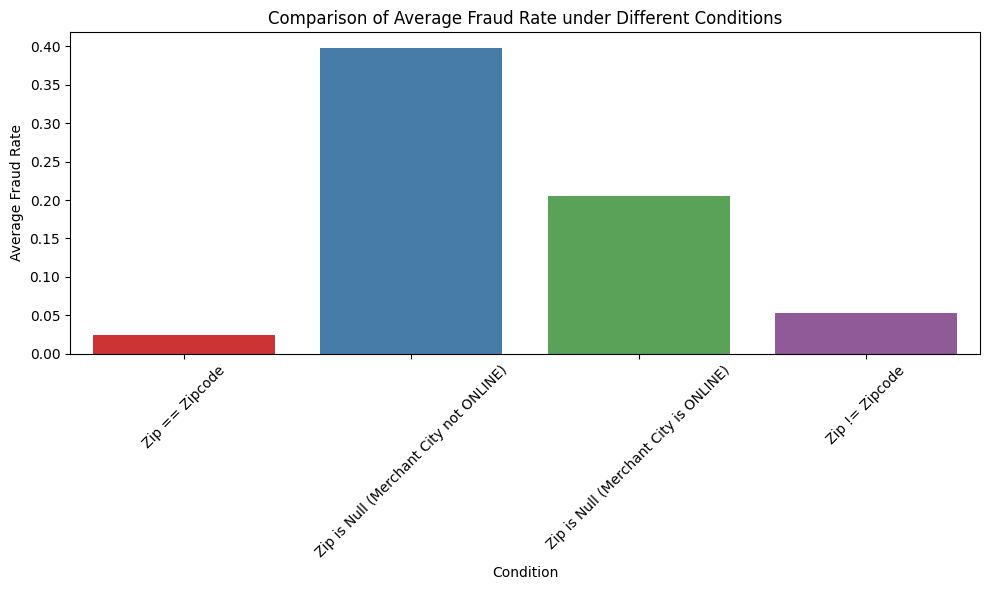

In [114]:
# FEATURE_IDEA: 店と家の郵便番号が同じかどうか、zipがnullならONLINEか否かの特徴量

# 各条件ごとにフィルタリング
condition1_data = all_data[(all_data["flag"] == "train") & (all_data["zip"] == all_data["zipcode"]) & (all_data["zip"].notnull())]
condition2_data = all_data[(all_data["flag"] == "train") & (all_data["zip"].isnull()) & (all_data["merchant_city"] != "ONLINE")]
condition3_data = all_data[(all_data["flag"] == "train") & (all_data["zip"].isnull()) & (all_data["merchant_city"] == "ONLINE")]
condition4_data = all_data[(all_data["flag"] == "train") & (all_data["zip"] != all_data["zipcode"]) & (all_data["zip"].notnull())]

# 各条件ごとの平均"is_fraud?"を計算
condition1_fraud_rate = condition1_data["is_fraud?"].mean()
condition2_fraud_rate = condition2_data["is_fraud?"].mean()
condition3_fraud_rate = condition3_data["is_fraud?"].mean()
condition4_fraud_rate = condition4_data["is_fraud?"].mean()

# データの比較用データフレームを作成
comparison_df = pd.DataFrame({
    "Condition": ["Zip == Zipcode", "Zip is Null (Merchant City not ONLINE)", "Zip is Null (Merchant City is ONLINE)", "Zip != Zipcode"],
    "Average Fraud Rate": [condition1_fraud_rate, condition2_fraud_rate, condition3_fraud_rate, condition4_fraud_rate]
})

# 可視化
plt.figure(figsize=(10, 6))
sns.barplot(x="Condition", y="Average Fraud Rate", data=comparison_df, palette="Set1")
plt.title("Comparison of Average Fraud Rate under Different Conditions")
plt.xlabel("Condition")
plt.ylabel("Average Fraud Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### user_id*mcc

In [117]:
train = all_data[all_data["flag"] == "train"].reset_index(drop=True)

In [118]:
train[["user_id", "mcc", "is_fraud?"]]

,user_id,mcc,is_fraud?
0,1721,5541,0.0
1,1629,5814,0.0
2,655,7538,0.0
3,492,5912,0.0
4,1969,4214,0.0
...,...,...,...
471278,1572,5541,0.0
471279,837,7922,1.0
471280,1522,5411,0.0
471281,1328,7349,0.0


C:\Users\Komiyama Yuji\AppData\Local\Temp\ipykernel_24312\1273791021.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["multiple_appearances"] = train_data["concatenated_ids"].map(ids_counts) > 1


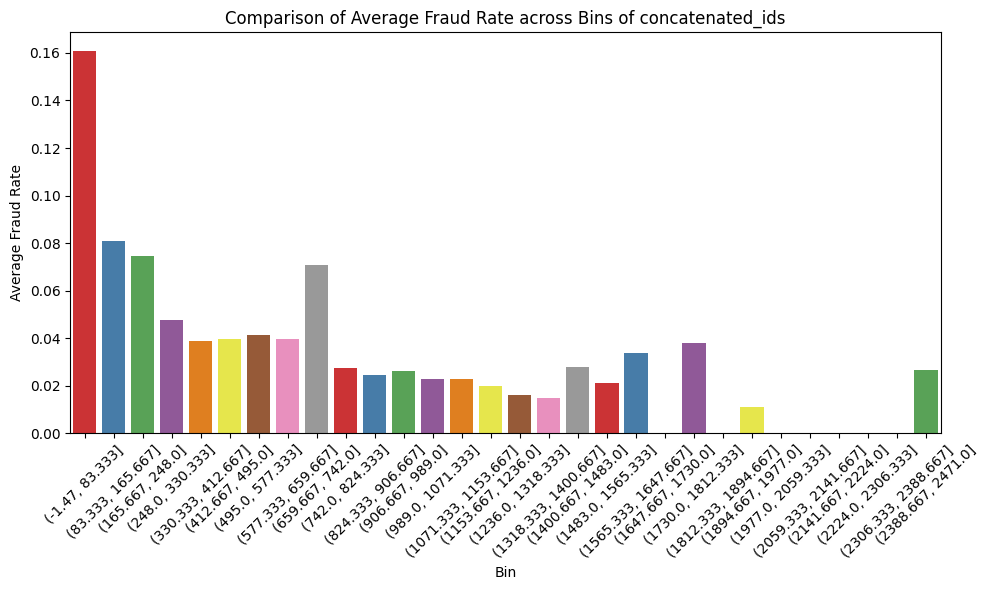

In [119]:
# FEATURE_IDEA: Cross Validationしたあとに過去にそのmccを使ったことがあるかどうか(or 回数)の特徴量を作る


all_data["concatenated_ids"] = all_data["user_id"].astype(str) + all_data["mcc"].astype(str)
# "flag"が"train"のデータを抽出
train_data = all_data[all_data["flag"] == "train"]

# "concatenated_ids"の出現回数を計算
ids_counts = train_data["concatenated_ids"].value_counts()

# "concatenated_ids"が複数回出現しているかどうかを判定し、新しいカラムを追加
train_data["multiple_appearances"] = train_data["concatenated_ids"].map(ids_counts) > 1

# 新しいDataFrameを作成
bins = pd.cut(ids_counts, bins=30)  # ヒストグラムのbin数を指定
binned_data = pd.DataFrame({
    "concatenated_ids": ids_counts.index,
    "bin": bins.values
})

# 各binの中での"is_fraud?"の平均を計算
bin_fraud_rate = binned_data.groupby("bin").apply(lambda x: train_data[train_data["concatenated_ids"].isin(x["concatenated_ids"])]["is_fraud?"].mean())

# 可視化
plt.figure(figsize=(10, 6))
sns.barplot(x=bin_fraud_rate.index, y=bin_fraud_rate.values, palette="Set1")
plt.title("Comparison of Average Fraud Rate across Bins of concatenated_ids")
plt.xlabel("Bin")
plt.ylabel("Average Fraud Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### user_id*use_chip

In [120]:
train[["user_id", "use_chip", "is_fraud?"]]

,user_id,use_chip,is_fraud?
0,1721,Swipe Transaction,0.0
1,1629,Swipe Transaction,0.0
2,655,Swipe Transaction,0.0
3,492,Chip Transaction,0.0
4,1969,Swipe Transaction,0.0
...,...,...,...
471278,1572,Chip Transaction,0.0
471279,837,Chip Transaction,1.0
471280,1522,Swipe Transaction,0.0
471281,1328,Online Transaction,0.0


In [156]:
# FEATURE_IDEA: CVしたあとに各use_chipの利用回数とその不正取引の平均を加える

# 各"user_id"ごとに"groupby"と"pivot_table"を使用して必要なデータを整形
data_unnested = train.groupby(["user_id", "use_chip"])["is_fraud?"].mean().unstack().reset_index()

# カラム名を修正
data_unnested.columns = ["user_id", "Chip Transaction", "Online Transaction", "Swipe Transaction"]

# 結果表示
data_unnested

,user_id,Chip Transaction,Online Transaction,Swipe Transaction
0,39,0.057734,0.141026,0.016226
1,41,0.017453,0.341270,0.043750
2,47,0.029745,0.139591,0.008671
3,54,0.028405,0.240545,0.025804
4,80,0.042553,0.209494,0.034192
...,...,...,...,...
92,1799,0.006110,0.327731,0.024269
93,1833,0.073099,0.394958,0.081603
94,1947,0.048748,0.193116,0.022007
95,1969,0.065031,0.208207,0.032534


### user_id*card_brand

In [160]:
train[["user_id", "card_brand", "is_fraud?"]]

,user_id,card_brand,is_fraud?
0,1721,Mastercard,0.0
1,1629,Mastercard,0.0
2,655,Mastercard,0.0
3,492,Visa,0.0
4,1969,Visa,0.0
...,...,...,...
471278,1572,Visa,0.0
471279,837,Mastercard,1.0
471280,1522,Visa,0.0
471281,1328,Visa,0.0


In [165]:
# FEATURE_IDEA: CVしたあとに各card_brandの利用回数とその不正取引の平均を加える

# 各"user_id"ごとに"groupby"と"pivot_table"を使用して必要なデータを整形
data_unnested = train.groupby(["user_id", "card_brand"])["is_fraud?"].mean().unstack().reset_index()

# カラム名を修正
data_unnested.columns = ["user_id", "Amex", "Discover", "Mastercard", "Visa"]

# 結果表示
data_unnested

,user_id,Amex,Discover,Mastercard,Visa
0,39,0.108209,NaN,NaN,0.017703
1,41,NaN,0.010739,0.103397,NaN
2,47,NaN,NaN,0.108333,0.010361
3,54,NaN,NaN,0.088747,0.035714
4,80,NaN,NaN,0.086355,0.072748
...,...,...,...,...,...
92,1799,NaN,NaN,0.051370,NaN
93,1833,NaN,0.014670,0.019666,0.256852
94,1947,0.181951,NaN,0.032235,0.041678
95,1969,NaN,NaN,0.072205,0.021879


### user_id*card_type

In [168]:
# FEATURE_IDEA: CVしたあとに各card_brandの利用回数とその不正取引の平均を加える

# 各"user_id"ごとに"groupby"と"pivot_table"を使用して必要なデータを整形
data_unnested = train.groupby(["user_id", "card_type"])["is_fraud?"].mean().unstack().reset_index()

# カラム名を修正
data_unnested.columns = ["user_id", "Credit", "Debit", "Debit (Prepaid)"]

# 結果表示
data_unnested

,user_id,Credit,Debit,Debit (Prepaid)
0,39,0.108209,0.017703,NaN
1,41,0.010739,0.103397,NaN
2,47,0.109890,0.010288,NaN
3,54,0.020956,0.082974,NaN
4,80,NaN,0.077764,NaN
...,...,...,...,...
92,1799,NaN,0.051370,NaN
93,1833,0.014670,0.151700,NaN
94,1947,0.087276,0.013759,0.000000
95,1969,0.089129,0.047336,NaN


### user_id*expires  
無理そう

### user_id*cards_issued

In [171]:
train[["user_id", "cards_issued", "is_fraud?"]]

,user_id,cards_issued,is_fraud?
0,1721,1,0.0
1,1629,2,0.0
2,655,1,0.0
3,492,1,0.0
4,1969,1,0.0
...,...,...,...
471278,1572,2,0.0
471279,837,1,1.0
471280,1522,1,0.0
471281,1328,2,0.0


In [173]:
len((train["user_id"].astype(str) + train["cards_issued"].astype(str)).unique())

169

### user_id*credit_limit

In [176]:
train[["user_id", "credit_limit", "is_fraud?"]]

,user_id,credit_limit,is_fraud?
0,1721,6900.0,0.0
1,1629,110.0,0.0
2,655,24090.0,0.0
3,492,10300.0,0.0
4,1969,11592.0,0.0
...,...,...,...
471278,1572,37325.0,0.0
471279,837,19811.0,1.0
471280,1522,23018.0,0.0
471281,1328,19037.0,0.0


上限額が変わっている

In [177]:
len((train["user_id"].astype(str) + train["credit_limit"].astype(str)).unique())

410

In [189]:
train

,index,user_id,card_id,amount,errors?,is_fraud?,merchant_id,merchant_city,merchant_state,zip,...,per_capita_income_zipcode,yearly_income_person,total_debt,fico_score,num_credit_cards,expires_month,expires_year,acct_open_date_month,acct_open_date_year,concatenated_ids
0,0,1721,0,2.623,OK,0.0,209237,Joliet,IL,60436.0,...,17567.0,35823.0,96691.0,732,3,10,2021,9,1995,1721IL
1,1,1629,3,6.400,OK,0.0,2568,Edgerton,WI,53534.0,...,21348.0,43529.0,126175.0,797,6,12,2022,6,1999,1629WI
2,2,655,3,123.500,OK,0.0,345310,Ridgefield,WA,98642.0,...,27308.0,55682.0,82696.0,750,4,5,2024,9,1998,655WA
3,3,492,0,51.287,OK,0.0,4295,Milton,FL,32583.0,...,20153.0,39082.0,16870.0,722,4,3,2022,4,1993,492FL
4,4,1969,4,17.561,OK,0.0,350447,Irvington,NJ,7111.0,...,16770.0,34190.0,39242.0,810,7,6,2023,8,1998,1969NJ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471278,471278,1572,0,51.245,OK,0.0,325177,Lake Orion,MI,48362.0,...,25838.0,52680.0,87082.0,835,5,7,2021,11,2014,1572MI
471279,471279,837,2,95.717,OK,1.0,405215,Norcross,GA,30092.0,...,22682.0,34220.0,0.0,745,5,10,2023,8,2013,837GA
471280,471280,1522,1,49.000,OK,0.0,291280,Novato,CA,94947.0,...,30335.0,61846.0,12525.0,722,4,5,2020,7,2010,1522CA
471281,471281,1328,1,22.868,OK,0.0,312028,ONLINE,NaN,NaN,...,19625.0,40012.0,59472.0,849,4,12,2023,4,2003,1328nan


In [185]:
[col for col in feature_lists if "index" not in col][39:50]

['card_id*amount',
 'card_id*errors?',
 'card_id*is_fraud?',
 'card_id*merchant_id',
 'card_id*merchant_city',
 'card_id*merchant_state',
 'card_id*zip',
 'card_id*mcc',
 'card_id*use_chip',
 'card_id*flag',
 'card_id*card_brand']